## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/Colab Notebooks/RL Assignment/TCGame_Env.py' .

In [8]:
!ls

drive  __pycache__  sample_data  TCGame_Env.py


In [10]:
import TCGame_Env

In [12]:
from TCGame_Env import TicTacToe 
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
## defining object for the Tictac toe environment created as MDP in TCGame_env
env = TicTacToe()

In [13]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [14]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [15]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [16]:
# Defining epsilon-greedy policy which will add new Q values to the dictionary
def epsilon_greedy(state, time, min_epsilon, max_epsilon, decay_rate):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
        
    if z > epsilon: #Exploitation: this gets the action corresponding to max q-value of current state
        state_next = Q_state(state)
        action = max(Q_dict[state_next],key=Q_dict[state_next].get)   
    
    else: #Exploration: randomly choosing and action
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    
    
    return action




#### Tracking the state-action pairs for checking convergence - write your code here

In [17]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [18]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
  
  

  
  
  

In [19]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [20]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [21]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [22]:
NUM_EPISODES = 5000000
LR = 0.01                   # learning rate
GAMMA_VALUE = 0.9           # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.0001         # epsilon decay rate
threshold = 2000           # no of episodes after which states_tracked will be saved
policy_threshold = 3000     # no of episodes after which Q dictionary/table will be saved

### Q-update loop ---write your code here

In [23]:
import time 
start_time = time.time()

for episode in range(NUM_EPISODES):
    
    # initialize the environment
    env = TicTacToe() 
    curr_state = env.state    
    
    # boolean flag to indicate whether it is the final state
    done = False  
    
    # add the current state to dictionary
    add_to_dict(curr_state)  

    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode, min_epsilon, max_epsilon, decay_rate)   # apply epislon method
        next_state, reward, done = env.step(curr_state, curr_action) # get the rewards
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)

        # Update the rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
            # get the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA_VALUE*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigate to the next state
        curr_state = next_state
        
     # track the states
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        
        # save the states tracked
        save_obj(States_track,'States_tracking')
        print("States tracked for episode: " + str(episode))


    #save the Q-dict file after every policy_threshold episodes
    if ((episode+1)% policy_threshold) == 0:  
        
         # update the Q-dict policy
        save_obj(Q_dict,'Q_dict_policy')  
        print("Policy updated for episode: " + str(episode))    
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')


States tracked for episode: 1999
Policy updated for episode: 2999
States tracked for episode: 3999
States tracked for episode: 5999
Policy updated for episode: 5999
States tracked for episode: 7999
Policy updated for episode: 8999
States tracked for episode: 9999
States tracked for episode: 11999
Policy updated for episode: 11999
States tracked for episode: 13999
Policy updated for episode: 14999
States tracked for episode: 15999
States tracked for episode: 17999
Policy updated for episode: 17999
States tracked for episode: 19999
Policy updated for episode: 20999
States tracked for episode: 21999
States tracked for episode: 23999
Policy updated for episode: 23999
States tracked for episode: 25999
Policy updated for episode: 26999
States tracked for episode: 27999
States tracked for episode: 29999
Policy updated for episode: 29999
States tracked for episode: 31999
Policy updated for episode: 32999
States tracked for episode: 33999
States tracked for episode: 35999
Policy updated for epi

Check the Q-dictionary


In [24]:
!cp *.pkl '/content/drive/MyDrive/Colab Notebooks/RL Assignment/.'

In [25]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2520472530433493,
              (0, 3): -1.2521644662908975,
              (0, 5): -1.2544439164274044,
              (0, 7): -1.25333493138224,
              (0, 9): 5.167606709302177,
              (1, 1): -1.252968966488415,
              (1, 3): -1.2489611891563643,
              (1, 5): -1.2365838941474598,
              (1, 7): -1.2520533897103407,
              (1, 9): -1.2514010597995673,
              (2, 1): -1.2493894021792693,
              (2, 3): -1.256587731576256,
              (2, 5): -1.2435371896392389,
              (2, 7): -1.254152228990149,
              (2, 9): -1.2549730411347826,
              (3, 1): -1.2552269719334757,
              (3, 3): -1.254542689273197,
              (3, 5): -1.2566304066276452,
              (3, 7): -1.2465237421763316,
              (3, 9): -1.249432856282331,
              (4, 1): -1.2504742143914533,
              (4, 3): -1.2534628257382774,
              (4, 5): -1

In [26]:
len(Q_dict)

1433597

In [ ]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [ ]:
# Write the code for plotting the graphs for state-action pairs tracked

<function matplotlib.pyplot.show>

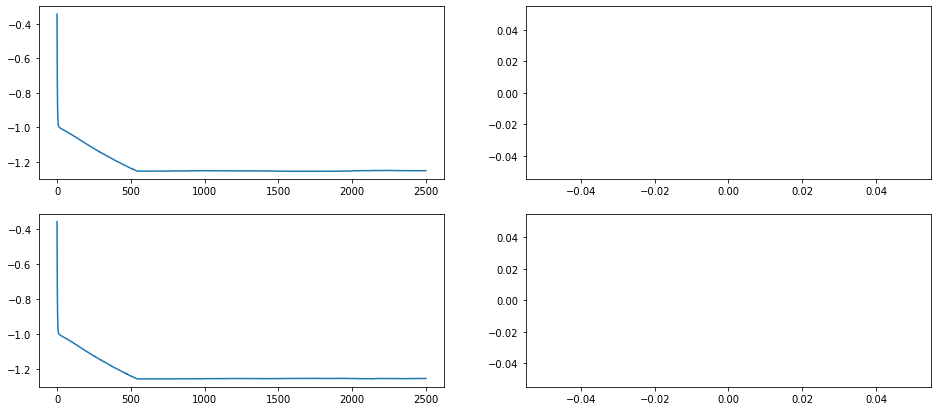

In [27]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-1-x-x-x-x'][(7,5)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-1-x-x-x-x'][(7,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-x-x-x-5-7-x'][(8,2)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-x-x-x-5-7-x'][(8,2)]))
plt.show

### Epsilon - decay check

In [28]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

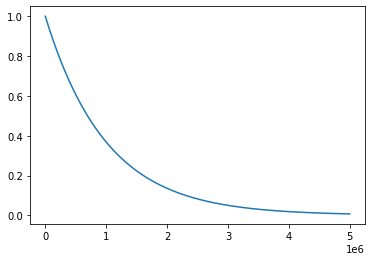

In [29]:
plt.plot(time, epsilon)
plt.show()